In [ ]:
import os
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys


sys.path.append("/content/drive/MyDrive/TUM Course Data/DI-Lab/segment-anything")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True


In [ ]:
img = sp.io.loadmat("/content/drive/MyDrive/TUM Course Data/DI-Lab/Datasets/Kaggle-OCT/Farsiu_Ophthalmology_2013_AMD_Subject_1002.mat")

In [ ]:
img['images'].shape

(512, 1000, 100)

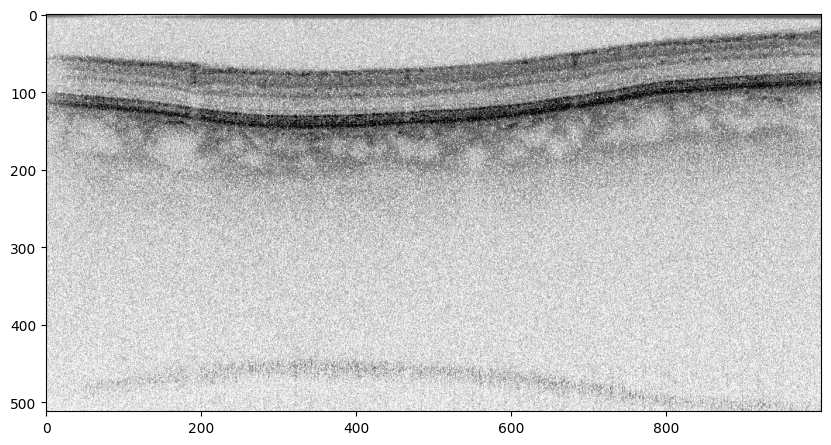

In [ ]:
fig = plt.figure(figsize=(10, 10))

def updatefig(i):
    fig.clear()
    plt.imshow(img['images'][:, :, i], cmap="Greys", vmin=0, vmax=255)
    plt.draw()

anim = animation.FuncAnimation(fig, updatefig, 90)
anim.save("test.mp4", fps=5)

In [ ]:
sam_checkpoint = "/content/drive/MyDrive/TUM Course Data/DI-Lab/sam_vit_l_0b3195.pth"
model_type = "vit_l"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-23): 24 x Block(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in range(len(colors)):
  h = colors[i].lstrip('#')
  colors[i] = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
print(colors)

[(230, 25, 75), (60, 180, 75), (255, 225, 25), (67, 99, 216), (245, 130, 49), (145, 30, 180), (70, 240, 240), (240, 50, 230), (188, 246, 12), (250, 190, 190), (0, 128, 128), (230, 190, 255), (154, 99, 36), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 216, 177), (0, 0, 117), (128, 128, 128)]


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for cl, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = colors[cl][i] / 255
        ax.imshow(np.dstack((img, m * 0.35)))

In [ ]:
def transform_image(img):
  image = np.expand_dims(img, axis=2)
  image = np.repeat(255 - image, 3, axis=2)
  return image

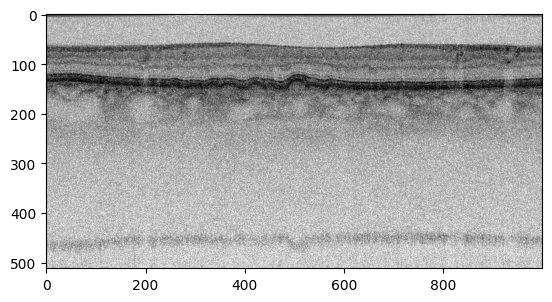

In [ ]:
plt.imshow(transform_image(img['images'][:, :, 41]))
plt.show()

In [ ]:
transform_image(img['images'][:, :, 41]).shape

(512, 1000, 3)

In [ ]:
masks = mask_generator_.generate(transform_image(img['images'][:, :, 25]))
print(len(masks))
plt.figure(figsize=(10, 10))
plt.imshow(transform_image(img['images'][:, :, 1]))
show_anns(masks)
plt.axis('off')
plt.show()

NameError: ignored

0 3
0 3
1 4
2 3
3 5
4 3
5 5
6 5
7 4
8 4
9 3
10 5
11 4
12 5
13 4
14 4
15 4
16 5
17 4
18 3
19 3
20 5
21 4
22 6
23 5
24 5
25 8
26 5
27 3
28 4
29 5
30 5
31 4
32 4
33 3
34 4
35 3
36 3
37 6
38 3
39 3
0 3


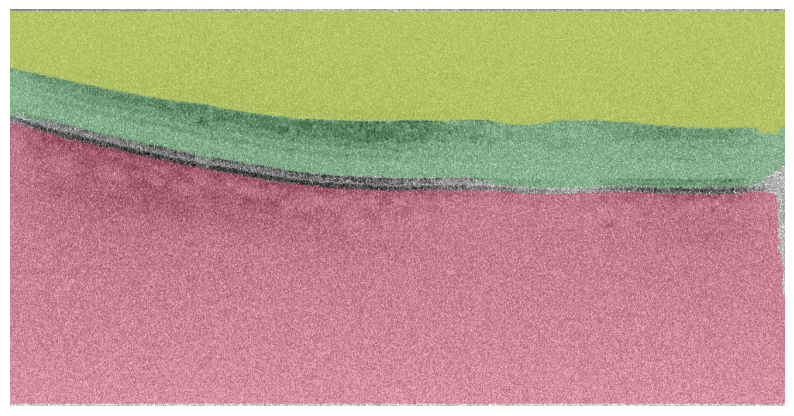

In [ ]:
fig = plt.figure(figsize=(10, 10))

def updatefig(i):
    fig.clear()
    try:
      masks = mask_generator_.generate(transform_image(img['images'][:, :, i]))
    except Exception as e:
      print(f"Got exception for frame {i}")
      print(e)
      masks = []
    print(i, len(masks))
    plt.imshow(transform_image(img['images'][:, :, i]))
    show_anns(masks)
    plt.axis('off')
    plt.draw()

anim = animation.FuncAnimation(fig, updatefig, 40)
anim.save("test.mp4", fps=5)